# Install all kinds of requirements

In [1]:
!apt install libglfw3-dev -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libglfw3-dev


In [2]:
%pip install IPython
%pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
%pip install matplotlib
%pip install flax
%pip install einops

from IPython.display import HTML, clear_output
clear_output()

import functools
import os
from datetime import datetime

import jax
import matplotlib.pyplot as plt
from jax import numpy as jp

try:
    import brax
except ImportError:
    %pip install git+https://github.com/google/brax.git@main
    clear_output()
    import brax

import flax
from brax import envs
from brax import geometry as braxgeo
from brax.io import html, json, model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

from einops import rearrange, repeat

## Double check GPU

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Train the agent on the base reward

In [4]:
env = envs.create(env_name="ant", backend="positional")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

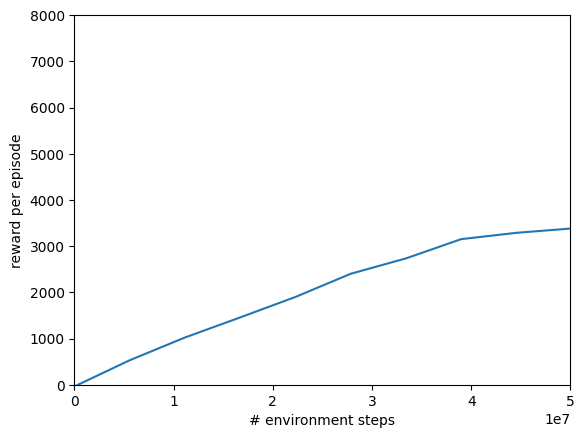

time to jit: 0:00:31.765687
time to train: 0:03:06.972620


In [ ]:
max_y = 8000
min_y = 0

xdata, ydata = [], []
times = [datetime.now()]


def progress(num_steps, metrics):
    times.append(datetime.now())
    xdata.append(num_steps)
    ydata.append(metrics["eval/episode_reward"])
    clear_output(wait=True)
    plt.xlim([0, 50_000_000])
    plt.ylim([min_y, max_y])
    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.plot(xdata, ydata)
    plt.show()


make_inference_fn, params, _ = ppo.train(
    environment=env,
    progress_fn=progress,
    num_timesteps=50_000_000,
    num_evals=10,
    reward_scaling=10,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=5,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=4096,
    batch_size=2048,
    seed=1,
)


print(f"time to jit: {times[1] - times[0]}")
print(f"time to train: {times[-1] - times[1]}")

In [ ]:
model.save_params("/tmp/params", params)
params = model.load_params("/tmp/params")
inference_fn = make_inference_fn(params)

## Visualize

In [ ]:
# @title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name="ant", backend="positional")

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
for _ in range(1000):
    rollout.append(state.pipeline_state)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_env_step(state, act)

HTML(html.render(env.sys.replace(dt=env.dt), rollout))

# Make the other reward functions

In [ ]:
# @jax.jit
def flying_reward(state: envs.State, action: jax.Array) -> jax.Array:
    contact = braxgeo.contact(  # type: brax.base.Contact
        env.sys, state.pipeline_state.x  # type: ignore
    )

    num_contacts = contact.link_idx[0].shape[0]  # type: ignore

    return state.reward + num_contacts * -0.25

In [ ]:
@jax.jit
def lazy_reward(state: envs.State, action: jax.Array) -> jax.Array:
    movement = jp.linalg.norm(action, axis=-1)

    return state.reward + movement * -0.5

In [ ]:
@jax.jit
def steady_reward(state: envs.State, action: jax.Array) -> jax.Array:
    body_y_vel = state.pipeline_state.xd.vel[0]  # type: ignore

    return state.reward + body_y_vel**2 * -0.5

In [ ]:
@jax.jit
def tall_reward(state: envs.State, action: jax.Array) -> jax.Array:
    z_height = state.pipeline_state.x.pos[0][2]  # type: ignore

    return state.reward + z_height * 0.25

## Add reward functions to reward_flavors array

In [ ]:
reward_flavors = [flying_reward, lazy_reward, steady_reward, tall_reward]

# Collecting Rollouts to Rank

In [ ]:
env = envs.create(env_name="ant", backend="positional")

jit_vec_env_reset = jax.jit(env.reset)
jit_vec_env_step = jax.jit(env.step)

rollouts = []
rng = jax.random.PRNGKey(seed=1)
states = jit_env_reset(rng=rng)

parallel_envs = 256
num_rollouts = 4096
trajectory_length = 1000

In [ ]:
vmapped_reset = jax.vmap(jit_env_reset)
vmapped_step = jax.vmap(jit_env_step)
vmapped_inference_fn = jax.vmap(jit_inference_fn)

In [ ]:
@jax.jit
def collect_rollout(
    rng: jax.Array
):
    rng, reset_rng = jax.random.split(rng)
    initial_state = jax.jit(env.reset)(rng=reset_rng)

    def scan_fn(state, rng):
        acts, _ = inference_fn(states.obs, rng)
        return jax.jit(env.step)(state, acts), (states, acts)

    rng, scan_rng = jax.random.split(rng)
    final_state, rollout = jax.lax.scan(
        f=scan_fn,
        init=initial_state,
        xs=jax.random.split(scan_rng, trajectory_length),
    )

    return rollout

In [19]:
def scan_fn(_, rng):
    # jax.debug.print("collecting batch")

    env_rngs = jax.random.split(rng, parallel_envs)
    rollout_batch = jax.vmap(collect_rollout)(env_rngs)
    rollout_batch = jax.device_put(rollout_batch, jax.devices("cpu")[0])

    # jax.debug.print("rollout_batch: {}", 3)

    return None, rollout_batch


rng, scan_rng = jax.random.split(rng)
_, rollout_batches = jax.lax.scan(
    f=scan_fn, init=None, xs=jax.random.split(scan_rng, num_rollouts // parallel_envs)
)

rollouts = jax.tree_map(lambda x: rearrange(x, "b e ... -> (b e) ..."), rollout_batches)

del rollout_batches

2023-05-14 08:13:09.871927: W external/tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 421.88MiB (rounded to 442368000)requested by op 
2023-05-14 08:13:09.885379: W external/tsl/tsl/framework/bfc_allocator.cc:497] ****************************************************************************************************
2023-05-14 08:13:09.885544: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2469] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 442368000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  421.88MiB
              constant allocation:         0B
        maybe_live_out allocation:  421.88MiB
     preallocated temp allocation:         0B
                 total allocation:  843.75MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 421.88MiB
		Entry Parameter Subshape: f32[16,256,27000]

	Buffer

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 442368000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  421.88MiB
              constant allocation:         0B
        maybe_live_out allocation:  421.88MiB
     preallocated temp allocation:         0B
                 total allocation:  843.75MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 421.88MiB
		Entry Parameter Subshape: f32[16,256,27000]
		==========================

	Buffer 2:
		Size: 421.88MiB
		XLA Label: copy
		Shape: f32[4096,1000,9,3]
		==========================



In [ ]:
for reward_flavor in reward_flavors:
    
    def trajectory_reward(state: envs.State, action: jax.Array):
        jax.lax.reduce(jax.vmap(reward_flavor)(state, action), 0, lambda a, b: a + b)
    
    all_rewards = jax.vmap(trajectory_reward)(*all_rollouts)
    print(f"{reward_flavor.__name__}: {all_rewards.mean()}")